# I. Get and save data from Astroquery

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<mark>The following Jupyter Notebook is used to extract and work with Gaia EDR3 / Gaia DR3 data (and other data releases) </mark>

## 1 -. Get data from Astroquery

Please read carefully before executing each Cell to check what it does. **Some cells need to be edited depending on your purposes** (such as changing number of data obtained, coordinates of the object, etc)
  

In [1]:
# Import all the libraries we will need

%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle, Latitude, Longitude
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Get data via Astroquery
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source" # Select early Data Release 3
Gaia.ROW_LIMIT = -1  # Set the number of max rows; -1 means 'no limit'

### Check coordinates for your object
### Important to check/edit before running the cell
object_name = 'NGC104'
c = SkyCoord('00h24m05s', '-72d04m53s', frame='icrs')
radius = u.Quantity(18.3, u.arcmin)
j = Gaia.cone_search_async(c, radius)

### Get results
r = j.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## 2 -. Row details and filtering data


### 2.1 -  Rows

Gaia data provides a series of data to play with. Here I just list the data you could find using Gaia EDR3 data via Astroquery with its respective data type, unit (if available) and description for each data (row).

For full details for every description please check [Official Gaia Webpage descriptions](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html).
    
| Column number | Column name | Data type | Units | Description |
| :--| :----------  |:------------: |  :-------: | :-------------------------------------------------------------:    |
| 0 |solution_id | int64 | -- | Solution Identifier |
| 1 |DESIGNATION | object | -- | Unique source designation (unique across all Data Releases) |
| 2 |source_id | int64 | -- | Unique source identifier (unique within a particular Data Release) |
| 3 |random_index | int64 | -- | Random index used to select subsets |
| 4 |ref_epoch | float64 | yr | Reference epoch |
| 5 |ra | float64 | deg | Right ascension |
| 6 |ra_error | float32 | mas | Standard error of right ascension |
| 7 |dec | float64 | deg | Declination |
| 8 |dec_error | float32 | mas | Standard error of declination |
| 9 |parallax | float64 | mas | Parallax |
| 10 |parallax_error | float32 | mas | Standard error of parallax |
| 11 |parallax_over_error | float32 | -- | Parallax divided by its standard error |
| 12 |pm | float32 | mas / yr | Total proper motion |
| 13 |pmra | float64 | mas / yr | Proper motion in right ascension direction |
| 14 |pmra_error | float32 | mas / yr | Standard error of proper motion in right ascension direction |
| 15 |pmdec | float64 | mas / yr | Proper motion in declination direction |
| 16 |pmdec_error | float32 | mas / yr | Standard error of proper motion in declination direction |
| 17 |ra_dec_corr | float32 | -- | Correlation between right ascension and declination |
| 18 |ra_parallax_corr | float32 | -- | Correlation between right ascension and parallax |
| 19 |ra_pmra_corr | float32 | -- | Correlation between right ascension and proper motion in right ascension |
| 20 |ra_pmdec_corr | float32 | -- | Correlation between right ascension and proper motion in declination |
| 21 |dec_parallax_corr | float32 | -- | Correlation between declination and parallax |
| 22 |dec_pmra_corr | float32 | -- | Correlation between declination and proper motion in right ascension |
| 23 |dec_pmdec_corr | float32 | -- | Correlation between declination and proper motion in declination |
| 24 |parallax_pmra_corr | float32 | -- | Correlation between parallax and proper motion in right ascension |
| 25 |parallax_pmdec_corr | float32 | -- | Correlation between parallax and proper motion in declination |
| 26 |pmra_pmdec_corr | float32 | -- | Correlation between proper motion in right ascension and proper motion in declination |
| 27 |astrometric_n_obs_al | int16 | -- | Total number of observations AL |
| 28 |astrometric_n_obs_ac | int16 | -- | Total number of observations AC |
| 29 |astrometric_n_good_obs_al | int16 | -- | Number of good observations AL |
| 30 |astrometric_n_bad_obs_al | int16 | -- | Number of bad observations AL |
| 31 |astrometric_gof_al | float32 | -- | Goodness of fit statistic of model wrt along-scan observations |
| 32 |astrometric_chi2_al | float32 | -- | AL chi-square value |
| 33 |astrometric_excess_noise | float32 | mas | Excess noise of the source |
| 34 |astrometric_excess_noise_sig | float32 | -- | Significance of excess noise |
| 35 |astrometric_params_solved | int16 | -- | Which parameters have been solved for? |
| 36 |astrometric_primary_flag | bool | -- | Primary or seconday |
| 37 |nu_eff_used_in_astrometry | float32 | 1 / um | Effective wavenumber of the source used in the astrometric solution |
| 38 |pseudocolour | float32 | 1 / um | Astrometrically estimated pseudocolour of the source |
| 39 |pseudocolour_error | float32 | 1 / um | Standard error of the pseudocolour of the source |
| 40 |ra_pseudocolour_corr | float32 | -- | Correlation between right ascension and pseudocolour |
| 41 |dec_pseudocolour_corr | float32 | -- | Correlation between declination and pseudocolour |
| 42 |parallax_pseudocolour_corr | float32 | -- | Correlation between parallax and pseudocolour |
| 43 |pmra_pseudocolour_corr | float32 | -- | Correlation between proper motion in right asension and pseudocolour |
| 44 |pmdec_pseudocolour_corr | float32 | -- | Correlation between proper motion in declination and pseudocolour |
| 45 |astrometric_matched_transits | int16 | -- | Matched FOV transits used in the AGIS solution |
| 46 |visibility_periods_used | int16 | -- | Number of visibility periods used in Astrometric solution |
| 47 |astrometric_sigma5d_max | float32 | mas | The longest semi-major axis of the 5-d error ellipsoid |
| 48 |matched_transits | int16 | -- | The number of transits matched to this source |
| 49 |new_matched_transits | int16 | -- | The number of transits newly incorporated into an existing source in the current cycle |
| 50 |matched_transits_removed | int16 | -- | The number of transits removed from an existing source in the current cycle |
| 51 |ipd_gof_harmonic_amplitude | float32 | -- | Amplitude of the IPD GoF versus position angle of scan |
| 52 |ipd_gof_harmonic_phase | float32 | deg | Phase of the IPD GoF versus position angle of scan |
| 53 |ipd_frac_multi_peak | int16 | -- | Percent of successful-IPD windows with more than one peak |
| 54 |ipd_frac_odd_win | int16 | -- | Percent of transits with truncated windows or multiple gate |
| 55 |ruwe | float32 | -- | Renormalised unit weight error |
| 56 |scan_direction_strength_k1 | float32 | -- | Degree of concentration of scan directions across the source |
| 57 |scan_direction_strength_k2 | float32 | -- | Degree of concentration of scan directions across the source |
| 58 |scan_direction_strength_k3 | float32 | -- | Degree of concentration of scan directions across the source |
| 59 |scan_direction_strength_k4 | float32 | -- | Degree of concentration of scan directions across the source |
| 60 |scan_direction_mean_k1 | float32 | deg | Mean position angle of scan directions across the source |
| 61 |scan_direction_mean_k2 | float32 | deg | Mean position angle of scan directions across the source |
| 62 |scan_direction_mean_k3 | float32 | deg | Mean position angle of scan directions across the source |
| 63 |scan_direction_mean_k4 | float32 | deg | Mean position angle of scan directions across the source |
| 64 |duplicated_source | bool | -- | Source with multiple source identifiers |
| 65 |phot_g_n_obs | int16 | -- | Number of observations contributing to G photometry |
| 66 |phot_g_mean_flux | float64 | electron / s | G-band mean flux |
| 67 |phot_g_mean_flux_error | float32 | electron / s | Error on G-band mean flux |
| 68 |phot_g_mean_flux_over_error | float32 | -- | G-band mean flux divided by its error |
| 69 |phot_g_mean_mag | float32 | mag | G-band mean magnitude |
| 70 |phot_bp_n_obs | int16 | -- | Number of observations contributing to BP photometry |
| 71 |phot_bp_mean_flux | float64 | electron / s | Integrated BP mean flux |
| 72 |phot_bp_mean_flux_error | float32 | electron / s | Error on the integrated BP mean flux |
| 73 |phot_bp_mean_flux_over_error | float32 | -- | Integrated BP mean flux divided by its error |
| 74 |phot_bp_mean_mag | float32 | mag | Integrated BP mean magnitude |
| 75 |phot_rp_n_obs | int16 | -- | Number of observations contributing to RP photometry |
| 76 |phot_rp_mean_flux | float64 | electron / s | Integrated RP mean flux |
| 77 |phot_rp_mean_flux_error | float32 | electron / s | Error on the integrated RP mean flux |
| 78 |phot_rp_mean_flux_over_error | float32 | -- | Integrated RP mean flux divided by its error |
| 79 |phot_rp_mean_mag | float32 | mag | Integrated RP mean magnitude |
| 80 |phot_bp_n_contaminated_transits | int16 | -- | Number of BP contaminated transits |
| 81 |phot_bp_n_blended_transits | int16 | -- | Number of BP blended transits |
| 82 |phot_rp_n_contaminated_transits | int16 | -- | Number of RP contaminated transits |
| 83 |phot_rp_n_blended_transits | int16 | -- | Number of RP blended transits |
| 84 |phot_proc_mode | int16 | -- | Photometry processing mode |
| 85 |phot_bp_rp_excess_factor | float32 | -- | BP/RP excess factor |
| 86 |bp_rp | float32 | mag | BP - RP colour |
| 87 |bp_g | float32 | mag | BP - G colour |
| 88 |g_rp | float32 | mag | G - RP colour |
| 89 |dr2_radial_velocity | float32 | km / s | Radial velocity from Gaia DR2 |
| 90 |dr2_radial_velocity_error | float32 | km / s | Radial velocity error from Gaia DR2 |
| 91 |dr2_rv_nb_transits | int16 | -- | Number of transits used to compute radial velocity in Gaia DR2 |
| 92 |dr2_rv_template_teff | float32 | K | Teff of the template used to compute radial velocity in Gaia DR2 |
| 93 |dr2_rv_template_logg | float32 | log(cm.s**-2) | logg of the template used to compute radial velocity in Gaia DR2 |
| 94 |dr2_rv_template_fe_h | float32 | dex | Fe/H of the template used to compute radial velocity in Gaia DR2 |
| 95 |l | float64 | deg | Galactic longitude |
| 96 |b | float64 | deg | Galactic latitude |
| 97 |ecl_lon | float64 | deg | Ecliptic longitude |
| 98 |ecl_lat | float64 | deg | Ecliptic latitude |
| 99 |dist | float64 | -- | None |


### 2.2 - Filtering info/data

Now that we have identified data we can start to filter it.
For my purposes and following procedure from [Milone et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.479.5005M/abstract), [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [Cordoni et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) we will be applying the next filters to data and writing it into a new file that will be used into the next step. These are just primary filters. We will apply other filters into the next step. 

These primary filters, in summary, are the following:

1. Discard all values that do not contain measurements in proper motion (i.e., a 'None' or masked value).
- Proper motions (in RA or DEC) higher than 30 mas / yr or lower than -30 mas / yr are discarded.

2. Discard all values that do not contain/have an invalid value for magnitudes in any band (G_RP, G_BP or G).
- Faint objects (mags above 22) and objects that are super bright (brigthness lower than -15) are discarded.

3. Discard all data with a proper motion error, in right ascension or declination, greater than 0.35 mas/yr.

In [3]:
from astropy.io import ascii
from astropy.table import vstack, Table

### Filter values (EDITABLE)
max_pm_error = 0.35 # mas / yr
max_pm_ra = 30. # mas / yr
max_pm_dec = 30. # mas / yr


### Filter by proper motion errors
pmra_error_mask = r['pmra_error'] < max_pm_error
filtered_r = r[pmra_error_mask]

pmdec_error_mask = filtered_r['pmdec_error'] < max_pm_error
filtered_r = filtered_r[pmdec_error_mask]


### Filter by proper motion values
ra_error_mask =  filtered_r['pmra'] < max_pm_ra
filtered_r = filtered_r[ra_error_mask]
ra_error_mask =  filtered_r['pmra'] > (-1.0 * max_pm_ra)
filtered_r = filtered_r[ra_error_mask]


dec_error_mask = filtered_r['pmdec'] < max_pm_dec
filtered_r = filtered_r[dec_error_mask]
dec_error_mask = filtered_r['pmdec'] > (-1.0 * max_pm_dec)
filtered_r = filtered_r[dec_error_mask]


###Filter by magnitudes values
g_rp_mask = filtered_r['phot_rp_mean_mag'] < 22.
filtered_r = filtered_r[g_rp_mask]
g_rp_mask = filtered_r['phot_rp_mean_mag'] > -15.
filtered_r = filtered_r[g_rp_mask]


g_bp_mask = filtered_r['phot_bp_mean_mag'] < 22.
filtered_r = filtered_r[g_bp_mask]
g_bp_mask = filtered_r['phot_bp_mean_mag'] > -15.
filtered_r = filtered_r[g_bp_mask]

g_g_mask = filtered_r['phot_g_mean_mag'] < 22.
filtered_r = filtered_r[g_g_mask]
g_g_mask = filtered_r['phot_g_mean_mag'] > -15.
filtered_r = filtered_r[g_g_mask]


## 3 -. Check the results

Check if the size of the table has changed and if some values are ok.

In [4]:
filtered_r

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 4689639266844741376,4689639266844741376,248315409,2016.0,6.02136691234547,0.03614829,-72.08178209766417,0.038203694,0.25453234854622425,0.049008604,5.1936255,6.298877,5.6617517891245575,0.03889522,-2.760510205895979,0.069722205,0.15881474,0.57295907,-0.31715575,-0.016979266,0.3980301,-0.28275508,0.32767478,-0.39822227,0.29189822,-0.13266678,188,188,188,0,7.593357,1183.8691,0.24742751,46.445206,95,False,--,1.413932,0.008320735,-0.22223842,-0.17428787,-0.26221985,0.26117414,0.021077354,22,16,0.09851817,30,11,1,0.026478462,63.832985,52,0,1.4212763,--,--,--,--,--,--,--,--,False,176,510399.5223880645,1119.9948,455.716,11.417591,14,261019.41466749573,5897.2227,44.261414,11.79686,14,591638.0205337083,3826.6506,154.6099,10.317756,0,14,0,14,0,1.6705686,1.479104,0.37926865,1.0998354,--,--,0,--,--,--,305.8956701461039,-44.88873288494303,311.2507536227628,-62.352445002263345,0.0004292517928992766
1636042515805110273,Gaia EDR3 4689639468699960576,4689639468699960576,324808586,2016.0,6.019318644566016,0.030347591,-72.07951386012606,0.03250933,0.33627254754183805,0.033226866,10.120

Plot just to check by eye if the result is, somehow, what you are looking for:

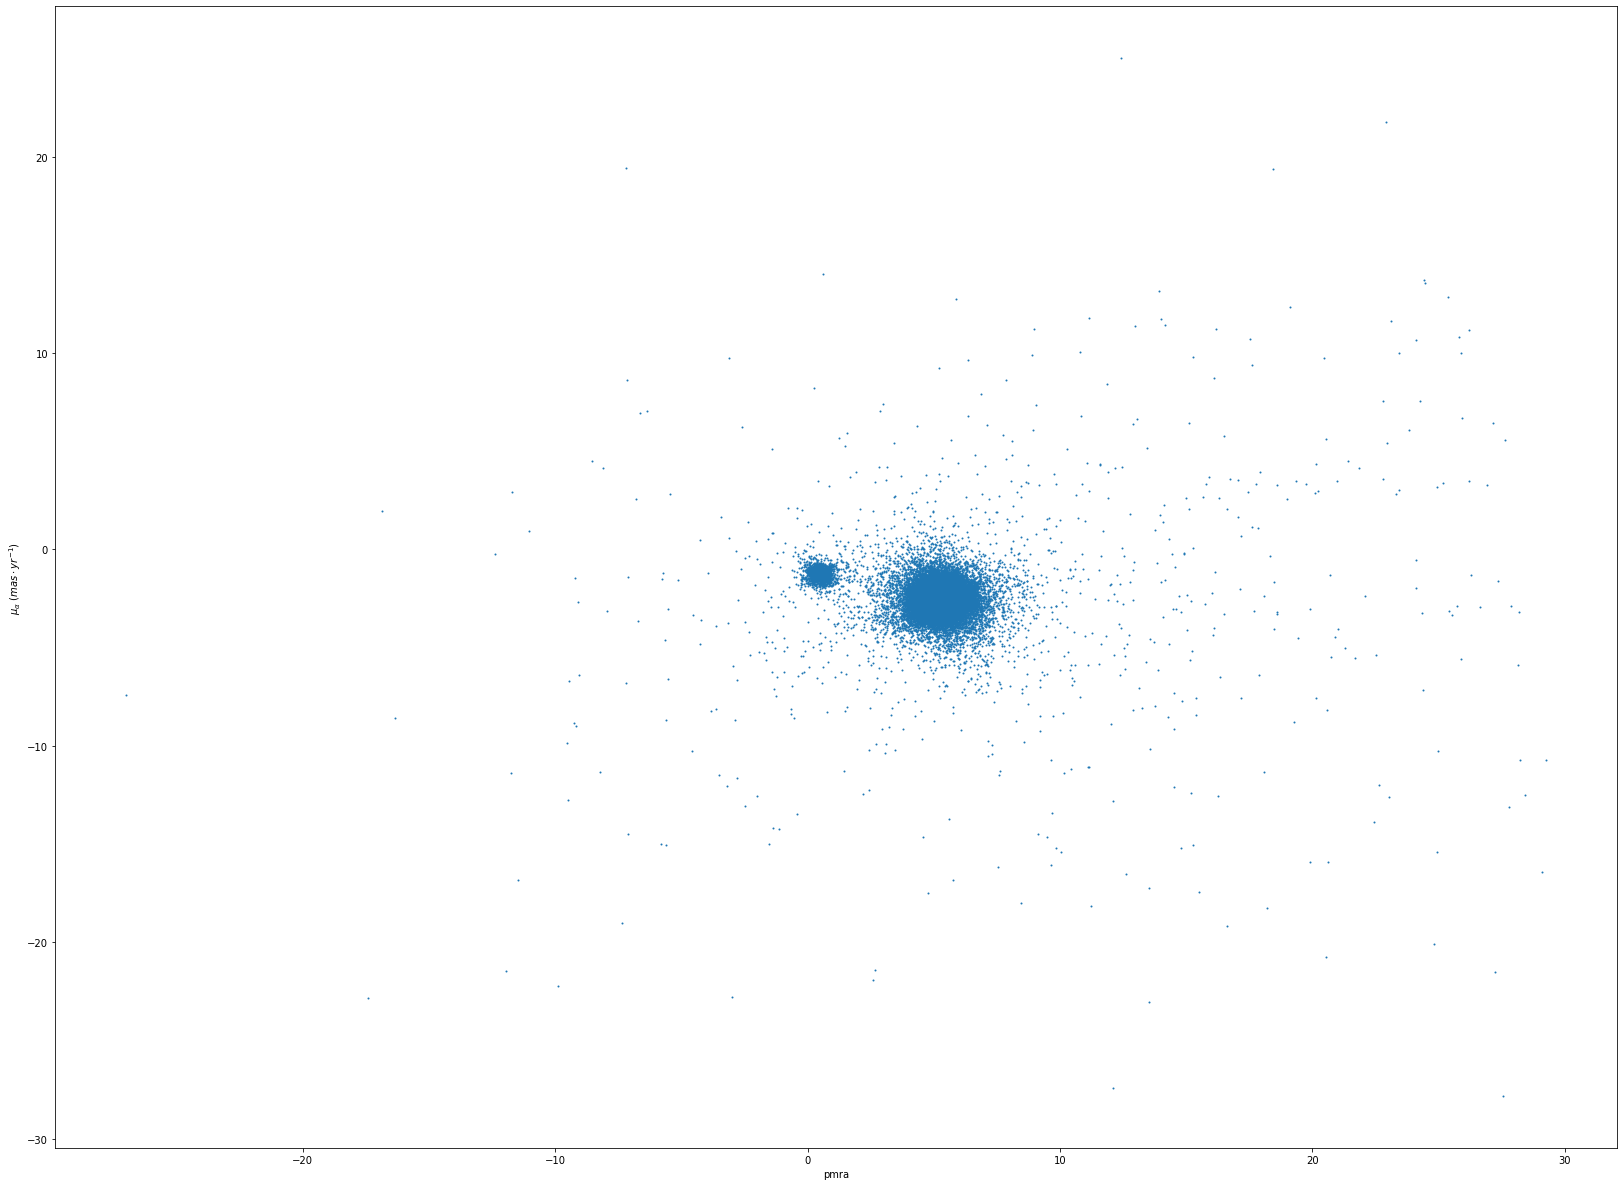

In [6]:
plt.scatter(filtered_r['pmra'], filtered_r['pmdec'], s = 1)
plt.ylabel(r'$\mu_\alpha \ (mas \cdot yr^{-1})$')
plt.xlabel('pmra')
plt.rcParams["figure.figsize"] = (28,21)
plt.show()